In [1]:
#导入库
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision #加载图片
from torchvision import transforms #图片变换

from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
 
import numpy as np
import matplotlib.pyplot as plt #绘图
import os
import glob
from PIL import Image
import random

from preprocess import Process
from transformer import *

In [2]:
seed = 32
def get_random_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
get_random_seed(seed)

In [3]:
#独热编码
def one_hot(x,class_count=10):
    return torch.eye(class_count)[x,:]

In [4]:
series = []
items = 3
step = 3
subject_num = 0

for num in range(2, 66):
    try:
        series += Process(num).prepro(1024, step, items)
        subject_num += 1
    except:
        print(f'subject {num} abandoned')

subject 13 abandoned
subject 16 abandoned
subject 17 abandoned
subject 18 abandoned
subject 20 abandoned
subject 26 abandoned


/home/dhz/anaconda3/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/dhz/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/home/dhz/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


subject 42 abandoned
subject 47 abandoned
subject 48 abandoned
subject 50 abandoned


In [5]:
class MyDataset(Dataset):
    def __init__(self, series, items, subject_num):
        self.series = series
        self.codes = []
        self.subject_num = subject_num
        self.labels = np.zeros((len(self.series), self.subject_num), dtype='double')
        for i in range(self.subject_num):
            for j in range(items):
                self.labels[i + j][i] = 1.0            

    # need to overload
    def __len__(self):
        return len(self.series)

    # need to overload
    def __getitem__(self, idx):
        return torch.tensor(self.series[idx]), torch.tensor(self.labels[idx])

In [6]:
dataset = MyDataset(series, items=items, subject_num=subject_num)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=16)

In [7]:
#定义生成器
class Generator(nn.Module):
    def __init__(self, subject_num):
        super(Generator,self).__init__()
        self.linear1 = nn.Linear(100,512)
        self.bn1=nn.BatchNorm1d(512)
        self.subject_num = subject_num
        self.linear2 = nn.Linear(subject_num,512)
        self.bn2=nn.BatchNorm1d(512)
        
        self.deconv1 = nn.Conv1d(1, 3, kernel_size=2, padding='same')
        self.bn3=nn.BatchNorm1d(3)
        self.deconv2 = nn.Conv1d(3, 6, kernel_size=2, padding='same')
        self.bn4=nn.BatchNorm1d(6)
        self.deconv3 = nn.Conv1d(6, 1, kernel_size=2, padding='same')
        
    def forward(self,x1,x2):
        x1=F.relu(self.linear1(x1.to(torch.float64)))
        x1=self.bn1(x1)
        x2=F.relu(self.linear2(x2))
        x2=self.bn2(x2)
        x=torch.cat([x1,x2],axis=1)
        x=F.relu(self.deconv1(torch.reshape(x, (x.size(0), 1, x.size(1)))))
        x=self.bn3(x)
        x=F.relu(self.deconv2(x))
        x=self.bn4(x)
        x=torch.tanh(self.deconv3(x))
        return x

In [8]:
#定义判别器
#输入：1，28，28图片和长度为10的condition
class Discriminator(nn.Module):
    def __init__(self, subject_num):
        super(Discriminator,self).__init__()
        self.subject_num = subject_num
        self.linear = nn.Linear(self.subject_num,1024)
        self.conv1 = nn.Conv1d(1,32,kernel_size=2,padding='same')
        self.conv2 = nn.Conv1d(32,128,kernel_size=2,padding='same')
        self.bn = nn.BatchNorm1d(128)
        self.fc = nn.Linear(2048,1)
    def forward(self,x1,x2): #x1代表label,x2代表image
        x1=F.leaky_relu(self.linear(x1))
        x=torch.cat([x1,x2],axis=1)            
        x= F.dropout1d(F.leaky_relu(self.conv1(torch.reshape(x, (x.size(0), 1, x.size(1))))))
        x= F.dropout1d(F.leaky_relu(self.conv2(x)))
        x = self.bn(x)
        x = torch.sigmoid(self.fc(x))
        return x

In [9]:
class ContinuityLoss(nn.Module):
    def __init__(self, weight=1.0):
        super(ContinuityLoss, self).__init__()
        self.weight = weight
        
    def forward(self, predictions):
        diff = predictions[:][1:] - predictions[:][:-1]
        loss = torch.mean(torch.abs(diff))
        return loss * self.weight

In [10]:
class MaxValueLoss(nn.Module):
    def __init__(self, weight=1.0):
        super(MaxValueLoss, self).__init__()
        self.weight = weight
        self.MCE = nn.CrossEntropyLoss()
    def forward(self, input1):
        input2 = torch.zeros_like(input1)
        types = torch.argmax(input1, dim = 0, keepdim=False)
        for i in range(input1.size(0)):
            input2[i][types[i]] = 1
        loss = self.MCE(input1, input2)
        return loss * self.weight

In [11]:
class ClassLoss(nn.Module):
    def __init__(self, weight=1.0):
        super(ClassLoss, self).__init__()
        self.weight = weight
    def forward(self, input1, input2):
        diff = input1 - input2
        loss = torch.mean(torch.abs(diff))
        return loss * self.weight

In [12]:
class ClassLoss(nn.Module):
    def __init__(self, weight=1.0):
        super(ClassLoss, self).__init__()
        self.weight = weight
        self.MCE = nn.CrossEntropyLoss()
    def forward(self, input1, input2):
        loss = self.MCE(input1, input2)
        return loss * self.weight

In [13]:
#设备的配置
device='cuda' if torch.cuda.is_available() else 'cpu'
#初化生成器和判别器把他们放到相应的设备上
gen = Generator(subject_num).to(device)
gen = gen.double()
dis = Discriminator(subject_num).to(device)
dis = dis.double()
cls = torch.load("classification").to(device)
cls = cls.double()
#交叉熵损失函数
loss_fn = torch.nn.BCELoss()
continue_loss_weight = 1
continue_loss = ContinuityLoss(weight=continue_loss_weight)
class_loss_weight = 0.5
class_loss = ClassLoss(weight=class_loss_weight)
#训练器的优化器
discriminator_rate = 1e-5
generator_rate = 1e-4
d_optimizer = torch.optim.Adam(dis.parameters(),lr=discriminator_rate)
#训练生成器的优化器
g_optimizer = torch.optim.Adam(gen.parameters(),lr=generator_rate)

In [14]:
#设置生成绘图图片的随机张量，这里可视化16张图片
#生成16个长度为100的随机正态分布张量
noise_seed = torch.randn(16,100,device=device)
label_seed = torch.randint(0,subject_num,size=(16,))
label_seed_onehot = one_hot(label_seed, class_count=subject_num).to(device)
 
D_loss = [] #记录训练过程中判别器的损失
G_loss = [] #记录训练过程中生成器的损失
S_loss = []
C_loss = []
accs = []
epoch_num = 4000

In [15]:
#训练循环
for epoch in range(epoch_num):
    #初始化损失值
    D_epoch_loss = 0
    G_epoch_loss = 0
    C_epoch_loss = 0
    S_epoch_loss = 0
    acc_num = 0
    item_num = 0
    count = len(dataloader.dataset) #返回批次数
    #对数据集进行迭代
    for step,(img,label) in enumerate(dataloader):
        img =img.to(device) #把数据放到设备上
        label = label.to(device)
        size = img.shape[0] #img的第一位是size,获取批次的大小
        random_seed = torch.randn(size,100,device=device)
        item_num += size
        
        #判别器训练(真实图片的损失和生成图片的损失),损失的构建和优化
        d_optimizer.zero_grad()#梯度归零
        #判别器对于真实图片产生的损失
        real_output = dis(label,img) #判别器输入真实的图片，real_output对真实图片的预测结果
        d_real_loss = loss_fn(real_output,
                              torch.ones_like(real_output,device=device)
                              )
        d_real_loss.backward()#计算梯度
        
        #在生成器上去计算生成器的损失，优化目标是判别器上的参数
        generated_img = gen(random_seed,label) #得到生成的图片
        
        #因为优化目标是判别器，所以对生成器上的优化目标进行截断
        generated_img = torch.reshape(generated_img, (generated_img.size(0), generated_img.size(2)))
        fake_output = dis(label,generated_img.detach()) #判别器输入生成的图片，fake_output对生成图片的预测;detach会截断梯度，梯度就不会再传递到gen模型中了
        #判别器在生成图像上产生的损失
        d_fake_loss = loss_fn(fake_output,
                              torch.zeros_like(fake_output,device=device)
                              )
        d_fake_loss.backward()
        #判别器损失
        disc_loss = d_real_loss + d_fake_loss
        #判别器优化
        d_optimizer.step()
        
        
        #生成器上损失的构建和优化
        g_optimizer.zero_grad() #先将生成器上的梯度置零
        fake_output = dis(label,generated_img)
        class_output = cls(torch.reshape(generated_img, (generated_img.size(0), 1, generated_img.size(1))))
        cls_loss = class_loss(class_output, label)
        series_loss = continue_loss(generated_img)
        for i in range(size):
            if class_output[i][torch.argmax(label[i])] >= 0.5:
                acc_num += 1
        gen_loss = loss_fn(fake_output,
                              torch.ones_like(fake_output,device=device)
                          ) + series_loss + cls_loss
        gen_loss.backward()
        g_optimizer.step()
        #累计每一个批次的loss
        with torch.no_grad():
            D_epoch_loss +=disc_loss
            G_epoch_loss +=gen_loss
            S_epoch_loss +=series_loss
            C_epoch_loss +=cls_loss
    #求平均损失
    with torch.no_grad():
        D_epoch_loss /=count
        G_epoch_loss /=count
        S_epoch_loss /=(count * continue_loss_weight)
        C_epoch_loss /=(count * class_loss_weight)
        acc = acc_num / item_num
        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)
        S_loss.append(S_epoch_loss)
        C_loss.append(C_epoch_loss)
        accs.append(acc)
        print(f"Epoch [{epoch + 1}/{epoch_num}], "
              f"Discriminator Loss: {D_epoch_loss:.4f}, "
              f"Generator Loss: {G_epoch_loss:.4f}, "
              f"Series Loss: {S_epoch_loss:.4f}, "
              f"Class Loss: {C_epoch_loss:.4f}, "
              f"Accuracy: {acc:.4f}")
        if acc > 0.8:
            break

/home/dhz/anaconda3/lib/python3.9/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch [1/4000], Discriminator Loss: 0.1067, Generator Loss: 0.2034, Series Loss: 0.0261, Class Loss: 0.2496, Accuracy: 0.0741
Epoch [2/4000], Discriminator Loss: 0.1031, Generator Loss: 0.2006, Series Loss: 0.0259, Class Loss: 0.2494, Accuracy: 0.0864
Epoch [3/4000], Discriminator Loss: 0.1004, Generator Loss: 0.1987, Series Loss: 0.0255, Class Loss: 0.2492, Accuracy: 0.1049
Epoch [4/4000], Discriminator Loss: 0.0986, Generator Loss: 0.1974, Series Loss: 0.0251, Class Loss: 0.2491, Accuracy: 0.0926
Epoch [5/4000], Discriminator Loss: 0.0970, Generator Loss: 0.1965, Series Loss: 0.0248, Class Loss: 0.2492, Accuracy: 0.1049
Epoch [6/4000], Discriminator Loss: 0.0961, Generator Loss: 0.1958, Series Loss: 0.0245, Class Loss: 0.2492, Accuracy: 0.0926
Epoch [7/4000], Discriminator Loss: 0.0955, Generator Loss: 0.1951, Series Loss: 0.0240, Class Loss: 0.2490, Accuracy: 0.1173
Epoch [8/4000], Discriminator Loss: 0.0958, Generator Loss: 0.1946, Series Loss: 0.0237, Class Loss: 0.2489, Accuracy:

Epoch [66/4000], Discriminator Loss: 0.0948, Generator Loss: 0.1789, Series Loss: 0.0090, Class Loss: 0.2467, Accuracy: 0.1790
Epoch [67/4000], Discriminator Loss: 0.0951, Generator Loss: 0.1784, Series Loss: 0.0088, Class Loss: 0.2466, Accuracy: 0.1790
Epoch [68/4000], Discriminator Loss: 0.0950, Generator Loss: 0.1783, Series Loss: 0.0086, Class Loss: 0.2465, Accuracy: 0.1790
Epoch [69/4000], Discriminator Loss: 0.0952, Generator Loss: 0.1782, Series Loss: 0.0086, Class Loss: 0.2466, Accuracy: 0.1728
Epoch [70/4000], Discriminator Loss: 0.0946, Generator Loss: 0.1780, Series Loss: 0.0084, Class Loss: 0.2465, Accuracy: 0.1728
Epoch [71/4000], Discriminator Loss: 0.0949, Generator Loss: 0.1781, Series Loss: 0.0082, Class Loss: 0.2466, Accuracy: 0.1605
Epoch [72/4000], Discriminator Loss: 0.0948, Generator Loss: 0.1778, Series Loss: 0.0081, Class Loss: 0.2465, Accuracy: 0.1605
Epoch [73/4000], Discriminator Loss: 0.0951, Generator Loss: 0.1776, Series Loss: 0.0080, Class Loss: 0.2465, A

Epoch [131/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1742, Series Loss: 0.0042, Class Loss: 0.2452, Accuracy: 0.2346
Epoch [132/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1742, Series Loss: 0.0042, Class Loss: 0.2451, Accuracy: 0.2407
Epoch [133/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1741, Series Loss: 0.0042, Class Loss: 0.2450, Accuracy: 0.2222
Epoch [134/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1739, Series Loss: 0.0041, Class Loss: 0.2450, Accuracy: 0.2407
Epoch [135/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1741, Series Loss: 0.0041, Class Loss: 0.2452, Accuracy: 0.2284
Epoch [136/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1740, Series Loss: 0.0041, Class Loss: 0.2451, Accuracy: 0.2531
Epoch [137/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1738, Series Loss: 0.0040, Class Loss: 0.2451, Accuracy: 0.2407
Epoch [138/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1740, Series Loss: 0.0040, Class Loss: 0

Epoch [196/4000], Discriminator Loss: 0.0896, Generator Loss: 0.1730, Series Loss: 0.0028, Class Loss: 0.2443, Accuracy: 0.6420
Epoch [197/4000], Discriminator Loss: 0.0897, Generator Loss: 0.1729, Series Loss: 0.0028, Class Loss: 0.2443, Accuracy: 0.6543
Epoch [198/4000], Discriminator Loss: 0.0896, Generator Loss: 0.1727, Series Loss: 0.0028, Class Loss: 0.2442, Accuracy: 0.6173
Epoch [199/4000], Discriminator Loss: 0.0895, Generator Loss: 0.1728, Series Loss: 0.0027, Class Loss: 0.2444, Accuracy: 0.6358
Epoch [200/4000], Discriminator Loss: 0.0899, Generator Loss: 0.1729, Series Loss: 0.0027, Class Loss: 0.2443, Accuracy: 0.6420
Epoch [201/4000], Discriminator Loss: 0.0896, Generator Loss: 0.1728, Series Loss: 0.0027, Class Loss: 0.2443, Accuracy: 0.6111
Epoch [202/4000], Discriminator Loss: 0.0896, Generator Loss: 0.1728, Series Loss: 0.0027, Class Loss: 0.2443, Accuracy: 0.6728
Epoch [203/4000], Discriminator Loss: 0.0895, Generator Loss: 0.1729, Series Loss: 0.0027, Class Loss: 0

Epoch [261/4000], Discriminator Loss: 0.0867, Generator Loss: 0.1740, Series Loss: 0.0023, Class Loss: 0.2438, Accuracy: 0.5309
Epoch [262/4000], Discriminator Loss: 0.0865, Generator Loss: 0.1738, Series Loss: 0.0023, Class Loss: 0.2438, Accuracy: 0.5185
Epoch [263/4000], Discriminator Loss: 0.0862, Generator Loss: 0.1739, Series Loss: 0.0023, Class Loss: 0.2439, Accuracy: 0.5432
Epoch [264/4000], Discriminator Loss: 0.0861, Generator Loss: 0.1742, Series Loss: 0.0023, Class Loss: 0.2440, Accuracy: 0.5370
Epoch [265/4000], Discriminator Loss: 0.0862, Generator Loss: 0.1742, Series Loss: 0.0023, Class Loss: 0.2438, Accuracy: 0.5494
Epoch [266/4000], Discriminator Loss: 0.0866, Generator Loss: 0.1743, Series Loss: 0.0023, Class Loss: 0.2439, Accuracy: 0.5062
Epoch [267/4000], Discriminator Loss: 0.0863, Generator Loss: 0.1741, Series Loss: 0.0023, Class Loss: 0.2439, Accuracy: 0.5741
Epoch [268/4000], Discriminator Loss: 0.0863, Generator Loss: 0.1743, Series Loss: 0.0023, Class Loss: 0

Epoch [326/4000], Discriminator Loss: 0.0840, Generator Loss: 0.1769, Series Loss: 0.0028, Class Loss: 0.2439, Accuracy: 0.2901
Epoch [327/4000], Discriminator Loss: 0.0840, Generator Loss: 0.1775, Series Loss: 0.0028, Class Loss: 0.2441, Accuracy: 0.3210
Epoch [328/4000], Discriminator Loss: 0.0836, Generator Loss: 0.1773, Series Loss: 0.0028, Class Loss: 0.2439, Accuracy: 0.3272
Epoch [329/4000], Discriminator Loss: 0.0836, Generator Loss: 0.1779, Series Loss: 0.0028, Class Loss: 0.2441, Accuracy: 0.3025
Epoch [330/4000], Discriminator Loss: 0.0838, Generator Loss: 0.1778, Series Loss: 0.0028, Class Loss: 0.2440, Accuracy: 0.3395
Epoch [331/4000], Discriminator Loss: 0.0836, Generator Loss: 0.1779, Series Loss: 0.0029, Class Loss: 0.2440, Accuracy: 0.2840
Epoch [332/4000], Discriminator Loss: 0.0835, Generator Loss: 0.1781, Series Loss: 0.0029, Class Loss: 0.2439, Accuracy: 0.3148
Epoch [333/4000], Discriminator Loss: 0.0839, Generator Loss: 0.1779, Series Loss: 0.0029, Class Loss: 0

Epoch [391/4000], Discriminator Loss: 0.0832, Generator Loss: 0.1799, Series Loss: 0.0046, Class Loss: 0.2447, Accuracy: 0.2346
Epoch [392/4000], Discriminator Loss: 0.0821, Generator Loss: 0.1803, Series Loss: 0.0047, Class Loss: 0.2446, Accuracy: 0.2407
Epoch [393/4000], Discriminator Loss: 0.0826, Generator Loss: 0.1799, Series Loss: 0.0048, Class Loss: 0.2445, Accuracy: 0.2407
Epoch [394/4000], Discriminator Loss: 0.0827, Generator Loss: 0.1796, Series Loss: 0.0048, Class Loss: 0.2447, Accuracy: 0.2469
Epoch [395/4000], Discriminator Loss: 0.0832, Generator Loss: 0.1800, Series Loss: 0.0048, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [396/4000], Discriminator Loss: 0.0834, Generator Loss: 0.1800, Series Loss: 0.0049, Class Loss: 0.2445, Accuracy: 0.2407
Epoch [397/4000], Discriminator Loss: 0.0831, Generator Loss: 0.1801, Series Loss: 0.0050, Class Loss: 0.2447, Accuracy: 0.2469
Epoch [398/4000], Discriminator Loss: 0.0833, Generator Loss: 0.1797, Series Loss: 0.0050, Class Loss: 0

Epoch [456/4000], Discriminator Loss: 0.0883, Generator Loss: 0.1813, Series Loss: 0.0090, Class Loss: 0.2446, Accuracy: 0.2531
Epoch [457/4000], Discriminator Loss: 0.0880, Generator Loss: 0.1813, Series Loss: 0.0091, Class Loss: 0.2446, Accuracy: 0.2346
Epoch [458/4000], Discriminator Loss: 0.0886, Generator Loss: 0.1808, Series Loss: 0.0092, Class Loss: 0.2446, Accuracy: 0.2531
Epoch [459/4000], Discriminator Loss: 0.0886, Generator Loss: 0.1812, Series Loss: 0.0091, Class Loss: 0.2446, Accuracy: 0.2531
Epoch [460/4000], Discriminator Loss: 0.0885, Generator Loss: 0.1813, Series Loss: 0.0093, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [461/4000], Discriminator Loss: 0.0881, Generator Loss: 0.1818, Series Loss: 0.0093, Class Loss: 0.2446, Accuracy: 0.2469
Epoch [462/4000], Discriminator Loss: 0.0888, Generator Loss: 0.1817, Series Loss: 0.0093, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [463/4000], Discriminator Loss: 0.0886, Generator Loss: 0.1819, Series Loss: 0.0094, Class Loss: 0

Epoch [521/4000], Discriminator Loss: 0.0899, Generator Loss: 0.1818, Series Loss: 0.0097, Class Loss: 0.2449, Accuracy: 0.2963
Epoch [522/4000], Discriminator Loss: 0.0892, Generator Loss: 0.1825, Series Loss: 0.0096, Class Loss: 0.2449, Accuracy: 0.3272
Epoch [523/4000], Discriminator Loss: 0.0903, Generator Loss: 0.1824, Series Loss: 0.0097, Class Loss: 0.2448, Accuracy: 0.3580
Epoch [524/4000], Discriminator Loss: 0.0889, Generator Loss: 0.1827, Series Loss: 0.0096, Class Loss: 0.2449, Accuracy: 0.3210
Epoch [525/4000], Discriminator Loss: 0.0907, Generator Loss: 0.1820, Series Loss: 0.0096, Class Loss: 0.2450, Accuracy: 0.2963
Epoch [526/4000], Discriminator Loss: 0.0904, Generator Loss: 0.1828, Series Loss: 0.0096, Class Loss: 0.2451, Accuracy: 0.3333
Epoch [527/4000], Discriminator Loss: 0.0895, Generator Loss: 0.1819, Series Loss: 0.0096, Class Loss: 0.2450, Accuracy: 0.2963
Epoch [528/4000], Discriminator Loss: 0.0893, Generator Loss: 0.1828, Series Loss: 0.0096, Class Loss: 0

Epoch [586/4000], Discriminator Loss: 0.0896, Generator Loss: 0.1835, Series Loss: 0.0097, Class Loss: 0.2449, Accuracy: 0.3086
Epoch [587/4000], Discriminator Loss: 0.0880, Generator Loss: 0.1840, Series Loss: 0.0097, Class Loss: 0.2449, Accuracy: 0.2840
Epoch [588/4000], Discriminator Loss: 0.0894, Generator Loss: 0.1833, Series Loss: 0.0097, Class Loss: 0.2449, Accuracy: 0.2901
Epoch [589/4000], Discriminator Loss: 0.0895, Generator Loss: 0.1836, Series Loss: 0.0097, Class Loss: 0.2450, Accuracy: 0.3025
Epoch [590/4000], Discriminator Loss: 0.0884, Generator Loss: 0.1840, Series Loss: 0.0098, Class Loss: 0.2448, Accuracy: 0.3025
Epoch [591/4000], Discriminator Loss: 0.0896, Generator Loss: 0.1828, Series Loss: 0.0096, Class Loss: 0.2449, Accuracy: 0.2901
Epoch [592/4000], Discriminator Loss: 0.0894, Generator Loss: 0.1837, Series Loss: 0.0097, Class Loss: 0.2451, Accuracy: 0.2778
Epoch [593/4000], Discriminator Loss: 0.0893, Generator Loss: 0.1840, Series Loss: 0.0097, Class Loss: 0

Epoch [651/4000], Discriminator Loss: 0.0892, Generator Loss: 0.1837, Series Loss: 0.0101, Class Loss: 0.2449, Accuracy: 0.2963
Epoch [652/4000], Discriminator Loss: 0.0890, Generator Loss: 0.1839, Series Loss: 0.0101, Class Loss: 0.2449, Accuracy: 0.2901
Epoch [653/4000], Discriminator Loss: 0.0900, Generator Loss: 0.1836, Series Loss: 0.0101, Class Loss: 0.2449, Accuracy: 0.2840
Epoch [654/4000], Discriminator Loss: 0.0894, Generator Loss: 0.1845, Series Loss: 0.0101, Class Loss: 0.2449, Accuracy: 0.2901
Epoch [655/4000], Discriminator Loss: 0.0893, Generator Loss: 0.1843, Series Loss: 0.0102, Class Loss: 0.2450, Accuracy: 0.2901
Epoch [656/4000], Discriminator Loss: 0.0893, Generator Loss: 0.1839, Series Loss: 0.0102, Class Loss: 0.2449, Accuracy: 0.2901
Epoch [657/4000], Discriminator Loss: 0.0894, Generator Loss: 0.1840, Series Loss: 0.0102, Class Loss: 0.2449, Accuracy: 0.3025
Epoch [658/4000], Discriminator Loss: 0.0887, Generator Loss: 0.1847, Series Loss: 0.0101, Class Loss: 0

Epoch [716/4000], Discriminator Loss: 0.0895, Generator Loss: 0.1839, Series Loss: 0.0102, Class Loss: 0.2448, Accuracy: 0.2963
Epoch [717/4000], Discriminator Loss: 0.0901, Generator Loss: 0.1839, Series Loss: 0.0101, Class Loss: 0.2449, Accuracy: 0.2840
Epoch [718/4000], Discriminator Loss: 0.0897, Generator Loss: 0.1834, Series Loss: 0.0100, Class Loss: 0.2447, Accuracy: 0.3025
Epoch [719/4000], Discriminator Loss: 0.0897, Generator Loss: 0.1838, Series Loss: 0.0101, Class Loss: 0.2448, Accuracy: 0.2840
Epoch [720/4000], Discriminator Loss: 0.0898, Generator Loss: 0.1836, Series Loss: 0.0101, Class Loss: 0.2449, Accuracy: 0.2840
Epoch [721/4000], Discriminator Loss: 0.0903, Generator Loss: 0.1835, Series Loss: 0.0101, Class Loss: 0.2449, Accuracy: 0.2963
Epoch [722/4000], Discriminator Loss: 0.0903, Generator Loss: 0.1835, Series Loss: 0.0102, Class Loss: 0.2448, Accuracy: 0.2840
Epoch [723/4000], Discriminator Loss: 0.0894, Generator Loss: 0.1838, Series Loss: 0.0103, Class Loss: 0

Epoch [781/4000], Discriminator Loss: 0.0911, Generator Loss: 0.1822, Series Loss: 0.0097, Class Loss: 0.2447, Accuracy: 0.2840
Epoch [782/4000], Discriminator Loss: 0.0904, Generator Loss: 0.1833, Series Loss: 0.0097, Class Loss: 0.2448, Accuracy: 0.2901
Epoch [783/4000], Discriminator Loss: 0.0901, Generator Loss: 0.1832, Series Loss: 0.0097, Class Loss: 0.2447, Accuracy: 0.3025
Epoch [784/4000], Discriminator Loss: 0.0895, Generator Loss: 0.1828, Series Loss: 0.0097, Class Loss: 0.2448, Accuracy: 0.2901
Epoch [785/4000], Discriminator Loss: 0.0906, Generator Loss: 0.1825, Series Loss: 0.0098, Class Loss: 0.2446, Accuracy: 0.2901
Epoch [786/4000], Discriminator Loss: 0.0896, Generator Loss: 0.1830, Series Loss: 0.0097, Class Loss: 0.2447, Accuracy: 0.3025
Epoch [787/4000], Discriminator Loss: 0.0894, Generator Loss: 0.1840, Series Loss: 0.0098, Class Loss: 0.2447, Accuracy: 0.2901
Epoch [788/4000], Discriminator Loss: 0.0899, Generator Loss: 0.1835, Series Loss: 0.0099, Class Loss: 0

Epoch [846/4000], Discriminator Loss: 0.0907, Generator Loss: 0.1814, Series Loss: 0.0095, Class Loss: 0.2447, Accuracy: 0.2840
Epoch [847/4000], Discriminator Loss: 0.0914, Generator Loss: 0.1821, Series Loss: 0.0096, Class Loss: 0.2446, Accuracy: 0.2901
Epoch [848/4000], Discriminator Loss: 0.0912, Generator Loss: 0.1821, Series Loss: 0.0095, Class Loss: 0.2447, Accuracy: 0.3025
Epoch [849/4000], Discriminator Loss: 0.0911, Generator Loss: 0.1826, Series Loss: 0.0095, Class Loss: 0.2448, Accuracy: 0.2963
Epoch [850/4000], Discriminator Loss: 0.0903, Generator Loss: 0.1827, Series Loss: 0.0096, Class Loss: 0.2447, Accuracy: 0.2963
Epoch [851/4000], Discriminator Loss: 0.0906, Generator Loss: 0.1818, Series Loss: 0.0094, Class Loss: 0.2445, Accuracy: 0.2963
Epoch [852/4000], Discriminator Loss: 0.0901, Generator Loss: 0.1824, Series Loss: 0.0095, Class Loss: 0.2446, Accuracy: 0.2901
Epoch [853/4000], Discriminator Loss: 0.0906, Generator Loss: 0.1822, Series Loss: 0.0095, Class Loss: 0

Epoch [911/4000], Discriminator Loss: 0.0909, Generator Loss: 0.1818, Series Loss: 0.0092, Class Loss: 0.2448, Accuracy: 0.2778
Epoch [912/4000], Discriminator Loss: 0.0905, Generator Loss: 0.1826, Series Loss: 0.0093, Class Loss: 0.2447, Accuracy: 0.2963
Epoch [913/4000], Discriminator Loss: 0.0903, Generator Loss: 0.1824, Series Loss: 0.0093, Class Loss: 0.2448, Accuracy: 0.2778
Epoch [914/4000], Discriminator Loss: 0.0904, Generator Loss: 0.1824, Series Loss: 0.0092, Class Loss: 0.2448, Accuracy: 0.2840
Epoch [915/4000], Discriminator Loss: 0.0913, Generator Loss: 0.1815, Series Loss: 0.0092, Class Loss: 0.2447, Accuracy: 0.2901
Epoch [916/4000], Discriminator Loss: 0.0910, Generator Loss: 0.1821, Series Loss: 0.0094, Class Loss: 0.2446, Accuracy: 0.2901
Epoch [917/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1819, Series Loss: 0.0092, Class Loss: 0.2447, Accuracy: 0.2963
Epoch [918/4000], Discriminator Loss: 0.0911, Generator Loss: 0.1824, Series Loss: 0.0093, Class Loss: 0

Epoch [976/4000], Discriminator Loss: 0.0923, Generator Loss: 0.1810, Series Loss: 0.0090, Class Loss: 0.2447, Accuracy: 0.2840
Epoch [977/4000], Discriminator Loss: 0.0923, Generator Loss: 0.1812, Series Loss: 0.0090, Class Loss: 0.2447, Accuracy: 0.2840
Epoch [978/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1813, Series Loss: 0.0091, Class Loss: 0.2446, Accuracy: 0.2840
Epoch [979/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1820, Series Loss: 0.0091, Class Loss: 0.2447, Accuracy: 0.2593
Epoch [980/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1816, Series Loss: 0.0090, Class Loss: 0.2446, Accuracy: 0.2840
Epoch [981/4000], Discriminator Loss: 0.0911, Generator Loss: 0.1815, Series Loss: 0.0091, Class Loss: 0.2447, Accuracy: 0.2778
Epoch [982/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1811, Series Loss: 0.0090, Class Loss: 0.2446, Accuracy: 0.2778
Epoch [983/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1814, Series Loss: 0.0090, Class Loss: 0

Epoch [1040/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1806, Series Loss: 0.0088, Class Loss: 0.2446, Accuracy: 0.3148
Epoch [1041/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1808, Series Loss: 0.0088, Class Loss: 0.2446, Accuracy: 0.3086
Epoch [1042/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1811, Series Loss: 0.0088, Class Loss: 0.2446, Accuracy: 0.2778
Epoch [1043/4000], Discriminator Loss: 0.0923, Generator Loss: 0.1806, Series Loss: 0.0088, Class Loss: 0.2446, Accuracy: 0.3025
Epoch [1044/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1808, Series Loss: 0.0088, Class Loss: 0.2446, Accuracy: 0.2840
Epoch [1045/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1810, Series Loss: 0.0089, Class Loss: 0.2447, Accuracy: 0.2840
Epoch [1046/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1809, Series Loss: 0.0088, Class Loss: 0.2447, Accuracy: 0.2840
Epoch [1047/4000], Discriminator Loss: 0.0924, Generator Loss: 0.1807, Series Loss: 0.0088, Class

Epoch [1104/4000], Discriminator Loss: 0.0930, Generator Loss: 0.1800, Series Loss: 0.0085, Class Loss: 0.2445, Accuracy: 0.2840
Epoch [1105/4000], Discriminator Loss: 0.0929, Generator Loss: 0.1804, Series Loss: 0.0086, Class Loss: 0.2446, Accuracy: 0.2963
Epoch [1106/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1809, Series Loss: 0.0087, Class Loss: 0.2446, Accuracy: 0.2901
Epoch [1107/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1803, Series Loss: 0.0086, Class Loss: 0.2448, Accuracy: 0.3086
Epoch [1108/4000], Discriminator Loss: 0.0930, Generator Loss: 0.1800, Series Loss: 0.0086, Class Loss: 0.2447, Accuracy: 0.3025
Epoch [1109/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1801, Series Loss: 0.0086, Class Loss: 0.2446, Accuracy: 0.3025
Epoch [1110/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1807, Series Loss: 0.0086, Class Loss: 0.2446, Accuracy: 0.2963
Epoch [1111/4000], Discriminator Loss: 0.0928, Generator Loss: 0.1798, Series Loss: 0.0086, Class

Epoch [1168/4000], Discriminator Loss: 0.0931, Generator Loss: 0.1799, Series Loss: 0.0082, Class Loss: 0.2445, Accuracy: 0.3395
Epoch [1169/4000], Discriminator Loss: 0.0928, Generator Loss: 0.1802, Series Loss: 0.0084, Class Loss: 0.2445, Accuracy: 0.3025
Epoch [1170/4000], Discriminator Loss: 0.0929, Generator Loss: 0.1804, Series Loss: 0.0084, Class Loss: 0.2446, Accuracy: 0.3086
Epoch [1171/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1804, Series Loss: 0.0084, Class Loss: 0.2447, Accuracy: 0.3210
Epoch [1172/4000], Discriminator Loss: 0.0935, Generator Loss: 0.1799, Series Loss: 0.0083, Class Loss: 0.2445, Accuracy: 0.3210
Epoch [1173/4000], Discriminator Loss: 0.0929, Generator Loss: 0.1806, Series Loss: 0.0084, Class Loss: 0.2447, Accuracy: 0.3519
Epoch [1174/4000], Discriminator Loss: 0.0931, Generator Loss: 0.1802, Series Loss: 0.0083, Class Loss: 0.2446, Accuracy: 0.3704
Epoch [1175/4000], Discriminator Loss: 0.0936, Generator Loss: 0.1803, Series Loss: 0.0083, Class

Epoch [1232/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1802, Series Loss: 0.0084, Class Loss: 0.2445, Accuracy: 0.3148
Epoch [1233/4000], Discriminator Loss: 0.0933, Generator Loss: 0.1798, Series Loss: 0.0083, Class Loss: 0.2446, Accuracy: 0.3272
Epoch [1234/4000], Discriminator Loss: 0.0934, Generator Loss: 0.1793, Series Loss: 0.0083, Class Loss: 0.2445, Accuracy: 0.3333
Epoch [1235/4000], Discriminator Loss: 0.0931, Generator Loss: 0.1799, Series Loss: 0.0083, Class Loss: 0.2446, Accuracy: 0.3580
Epoch [1236/4000], Discriminator Loss: 0.0936, Generator Loss: 0.1796, Series Loss: 0.0083, Class Loss: 0.2447, Accuracy: 0.3457
Epoch [1237/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1801, Series Loss: 0.0082, Class Loss: 0.2446, Accuracy: 0.3210
Epoch [1238/4000], Discriminator Loss: 0.0932, Generator Loss: 0.1799, Series Loss: 0.0083, Class Loss: 0.2445, Accuracy: 0.3333
Epoch [1239/4000], Discriminator Loss: 0.0933, Generator Loss: 0.1797, Series Loss: 0.0081, Class

Epoch [1296/4000], Discriminator Loss: 0.0930, Generator Loss: 0.1801, Series Loss: 0.0079, Class Loss: 0.2447, Accuracy: 0.3148
Epoch [1297/4000], Discriminator Loss: 0.0930, Generator Loss: 0.1800, Series Loss: 0.0081, Class Loss: 0.2446, Accuracy: 0.3519
Epoch [1298/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1805, Series Loss: 0.0080, Class Loss: 0.2446, Accuracy: 0.3333
Epoch [1299/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1805, Series Loss: 0.0080, Class Loss: 0.2446, Accuracy: 0.3272
Epoch [1300/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1800, Series Loss: 0.0081, Class Loss: 0.2446, Accuracy: 0.3148
Epoch [1301/4000], Discriminator Loss: 0.0933, Generator Loss: 0.1797, Series Loss: 0.0081, Class Loss: 0.2446, Accuracy: 0.3272
Epoch [1302/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1799, Series Loss: 0.0081, Class Loss: 0.2446, Accuracy: 0.3395
Epoch [1303/4000], Discriminator Loss: 0.0933, Generator Loss: 0.1800, Series Loss: 0.0080, Class

Epoch [1360/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1792, Series Loss: 0.0078, Class Loss: 0.2445, Accuracy: 0.4321
Epoch [1361/4000], Discriminator Loss: 0.0934, Generator Loss: 0.1793, Series Loss: 0.0079, Class Loss: 0.2445, Accuracy: 0.3395
Epoch [1362/4000], Discriminator Loss: 0.0940, Generator Loss: 0.1792, Series Loss: 0.0079, Class Loss: 0.2446, Accuracy: 0.3765
Epoch [1363/4000], Discriminator Loss: 0.0928, Generator Loss: 0.1794, Series Loss: 0.0078, Class Loss: 0.2446, Accuracy: 0.4506
Epoch [1364/4000], Discriminator Loss: 0.0930, Generator Loss: 0.1795, Series Loss: 0.0078, Class Loss: 0.2446, Accuracy: 0.4568
Epoch [1365/4000], Discriminator Loss: 0.0929, Generator Loss: 0.1794, Series Loss: 0.0077, Class Loss: 0.2445, Accuracy: 0.4630
Epoch [1366/4000], Discriminator Loss: 0.0934, Generator Loss: 0.1797, Series Loss: 0.0079, Class Loss: 0.2445, Accuracy: 0.4074
Epoch [1367/4000], Discriminator Loss: 0.0931, Generator Loss: 0.1798, Series Loss: 0.0078, Class

Epoch [1424/4000], Discriminator Loss: 0.0928, Generator Loss: 0.1797, Series Loss: 0.0077, Class Loss: 0.2446, Accuracy: 0.3210
Epoch [1425/4000], Discriminator Loss: 0.0937, Generator Loss: 0.1789, Series Loss: 0.0076, Class Loss: 0.2445, Accuracy: 0.3333
Epoch [1426/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1794, Series Loss: 0.0077, Class Loss: 0.2445, Accuracy: 0.3272
Epoch [1427/4000], Discriminator Loss: 0.0933, Generator Loss: 0.1797, Series Loss: 0.0077, Class Loss: 0.2446, Accuracy: 0.3272
Epoch [1428/4000], Discriminator Loss: 0.0936, Generator Loss: 0.1791, Series Loss: 0.0077, Class Loss: 0.2446, Accuracy: 0.3086
Epoch [1429/4000], Discriminator Loss: 0.0935, Generator Loss: 0.1795, Series Loss: 0.0078, Class Loss: 0.2445, Accuracy: 0.3086
Epoch [1430/4000], Discriminator Loss: 0.0928, Generator Loss: 0.1796, Series Loss: 0.0077, Class Loss: 0.2445, Accuracy: 0.3025
Epoch [1431/4000], Discriminator Loss: 0.0933, Generator Loss: 0.1795, Series Loss: 0.0077, Class

Epoch [1488/4000], Discriminator Loss: 0.0933, Generator Loss: 0.1787, Series Loss: 0.0076, Class Loss: 0.2446, Accuracy: 0.3457
Epoch [1489/4000], Discriminator Loss: 0.0934, Generator Loss: 0.1788, Series Loss: 0.0076, Class Loss: 0.2445, Accuracy: 0.3395
Epoch [1490/4000], Discriminator Loss: 0.0932, Generator Loss: 0.1790, Series Loss: 0.0075, Class Loss: 0.2444, Accuracy: 0.3333
Epoch [1491/4000], Discriminator Loss: 0.0932, Generator Loss: 0.1788, Series Loss: 0.0075, Class Loss: 0.2445, Accuracy: 0.3642
Epoch [1492/4000], Discriminator Loss: 0.0934, Generator Loss: 0.1788, Series Loss: 0.0075, Class Loss: 0.2445, Accuracy: 0.3395
Epoch [1493/4000], Discriminator Loss: 0.0930, Generator Loss: 0.1792, Series Loss: 0.0075, Class Loss: 0.2445, Accuracy: 0.3333
Epoch [1494/4000], Discriminator Loss: 0.0929, Generator Loss: 0.1792, Series Loss: 0.0075, Class Loss: 0.2444, Accuracy: 0.3272
Epoch [1495/4000], Discriminator Loss: 0.0932, Generator Loss: 0.1790, Series Loss: 0.0074, Class

Epoch [1552/4000], Discriminator Loss: 0.0931, Generator Loss: 0.1789, Series Loss: 0.0073, Class Loss: 0.2444, Accuracy: 0.3642
Epoch [1553/4000], Discriminator Loss: 0.0928, Generator Loss: 0.1789, Series Loss: 0.0073, Class Loss: 0.2444, Accuracy: 0.3580
Epoch [1554/4000], Discriminator Loss: 0.0929, Generator Loss: 0.1785, Series Loss: 0.0073, Class Loss: 0.2444, Accuracy: 0.3086
Epoch [1555/4000], Discriminator Loss: 0.0928, Generator Loss: 0.1788, Series Loss: 0.0074, Class Loss: 0.2443, Accuracy: 0.3333
Epoch [1556/4000], Discriminator Loss: 0.0930, Generator Loss: 0.1782, Series Loss: 0.0074, Class Loss: 0.2445, Accuracy: 0.3333
Epoch [1557/4000], Discriminator Loss: 0.0928, Generator Loss: 0.1784, Series Loss: 0.0073, Class Loss: 0.2446, Accuracy: 0.3210
Epoch [1558/4000], Discriminator Loss: 0.0929, Generator Loss: 0.1785, Series Loss: 0.0074, Class Loss: 0.2445, Accuracy: 0.3333
Epoch [1559/4000], Discriminator Loss: 0.0930, Generator Loss: 0.1789, Series Loss: 0.0074, Class

Epoch [1616/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1792, Series Loss: 0.0072, Class Loss: 0.2445, Accuracy: 0.3210
Epoch [1617/4000], Discriminator Loss: 0.0931, Generator Loss: 0.1785, Series Loss: 0.0072, Class Loss: 0.2444, Accuracy: 0.3025
Epoch [1618/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1788, Series Loss: 0.0072, Class Loss: 0.2443, Accuracy: 0.3086
Epoch [1619/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1791, Series Loss: 0.0072, Class Loss: 0.2444, Accuracy: 0.3210
Epoch [1620/4000], Discriminator Loss: 0.0926, Generator Loss: 0.1785, Series Loss: 0.0072, Class Loss: 0.2444, Accuracy: 0.2963
Epoch [1621/4000], Discriminator Loss: 0.0926, Generator Loss: 0.1788, Series Loss: 0.0073, Class Loss: 0.2444, Accuracy: 0.3272
Epoch [1622/4000], Discriminator Loss: 0.0930, Generator Loss: 0.1784, Series Loss: 0.0071, Class Loss: 0.2443, Accuracy: 0.3210
Epoch [1623/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1787, Series Loss: 0.0073, Class

Epoch [1680/4000], Discriminator Loss: 0.0930, Generator Loss: 0.1784, Series Loss: 0.0070, Class Loss: 0.2445, Accuracy: 0.3148
Epoch [1681/4000], Discriminator Loss: 0.0932, Generator Loss: 0.1779, Series Loss: 0.0070, Class Loss: 0.2443, Accuracy: 0.3148
Epoch [1682/4000], Discriminator Loss: 0.0926, Generator Loss: 0.1779, Series Loss: 0.0070, Class Loss: 0.2444, Accuracy: 0.3272
Epoch [1683/4000], Discriminator Loss: 0.0926, Generator Loss: 0.1778, Series Loss: 0.0071, Class Loss: 0.2445, Accuracy: 0.3210
Epoch [1684/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1785, Series Loss: 0.0070, Class Loss: 0.2444, Accuracy: 0.3148
Epoch [1685/4000], Discriminator Loss: 0.0923, Generator Loss: 0.1785, Series Loss: 0.0071, Class Loss: 0.2443, Accuracy: 0.3148
Epoch [1686/4000], Discriminator Loss: 0.0930, Generator Loss: 0.1785, Series Loss: 0.0070, Class Loss: 0.2444, Accuracy: 0.3025
Epoch [1687/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1787, Series Loss: 0.0071, Class

Epoch [1744/4000], Discriminator Loss: 0.0930, Generator Loss: 0.1785, Series Loss: 0.0070, Class Loss: 0.2445, Accuracy: 0.2840
Epoch [1745/4000], Discriminator Loss: 0.0933, Generator Loss: 0.1782, Series Loss: 0.0069, Class Loss: 0.2445, Accuracy: 0.3025
Epoch [1746/4000], Discriminator Loss: 0.0924, Generator Loss: 0.1787, Series Loss: 0.0069, Class Loss: 0.2443, Accuracy: 0.2901
Epoch [1747/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1782, Series Loss: 0.0069, Class Loss: 0.2445, Accuracy: 0.3148
Epoch [1748/4000], Discriminator Loss: 0.0930, Generator Loss: 0.1778, Series Loss: 0.0069, Class Loss: 0.2443, Accuracy: 0.3148
Epoch [1749/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1784, Series Loss: 0.0069, Class Loss: 0.2445, Accuracy: 0.2840
Epoch [1750/4000], Discriminator Loss: 0.0926, Generator Loss: 0.1780, Series Loss: 0.0069, Class Loss: 0.2444, Accuracy: 0.3025
Epoch [1751/4000], Discriminator Loss: 0.0930, Generator Loss: 0.1779, Series Loss: 0.0070, Class

Epoch [1808/4000], Discriminator Loss: 0.0926, Generator Loss: 0.1784, Series Loss: 0.0069, Class Loss: 0.2444, Accuracy: 0.3272
Epoch [1809/4000], Discriminator Loss: 0.0924, Generator Loss: 0.1782, Series Loss: 0.0069, Class Loss: 0.2444, Accuracy: 0.3025
Epoch [1810/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1781, Series Loss: 0.0067, Class Loss: 0.2444, Accuracy: 0.3086
Epoch [1811/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1780, Series Loss: 0.0067, Class Loss: 0.2444, Accuracy: 0.3025
Epoch [1812/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1779, Series Loss: 0.0067, Class Loss: 0.2443, Accuracy: 0.3086
Epoch [1813/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1784, Series Loss: 0.0068, Class Loss: 0.2444, Accuracy: 0.2963
Epoch [1814/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1784, Series Loss: 0.0068, Class Loss: 0.2443, Accuracy: 0.2778
Epoch [1815/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1780, Series Loss: 0.0067, Class

Epoch [1872/4000], Discriminator Loss: 0.0929, Generator Loss: 0.1780, Series Loss: 0.0066, Class Loss: 0.2444, Accuracy: 0.2963
Epoch [1873/4000], Discriminator Loss: 0.0923, Generator Loss: 0.1778, Series Loss: 0.0067, Class Loss: 0.2445, Accuracy: 0.3025
Epoch [1874/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1777, Series Loss: 0.0066, Class Loss: 0.2445, Accuracy: 0.3148
Epoch [1875/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1782, Series Loss: 0.0067, Class Loss: 0.2445, Accuracy: 0.2840
Epoch [1876/4000], Discriminator Loss: 0.0926, Generator Loss: 0.1780, Series Loss: 0.0066, Class Loss: 0.2444, Accuracy: 0.2778
Epoch [1877/4000], Discriminator Loss: 0.0929, Generator Loss: 0.1784, Series Loss: 0.0066, Class Loss: 0.2444, Accuracy: 0.2901
Epoch [1878/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1777, Series Loss: 0.0066, Class Loss: 0.2444, Accuracy: 0.2840
Epoch [1879/4000], Discriminator Loss: 0.0928, Generator Loss: 0.1781, Series Loss: 0.0066, Class

Epoch [1936/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1776, Series Loss: 0.0064, Class Loss: 0.2444, Accuracy: 0.2778
Epoch [1937/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1776, Series Loss: 0.0063, Class Loss: 0.2443, Accuracy: 0.2963
Epoch [1938/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1775, Series Loss: 0.0064, Class Loss: 0.2443, Accuracy: 0.2901
Epoch [1939/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1779, Series Loss: 0.0064, Class Loss: 0.2444, Accuracy: 0.2901
Epoch [1940/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1778, Series Loss: 0.0064, Class Loss: 0.2445, Accuracy: 0.3086
Epoch [1941/4000], Discriminator Loss: 0.0928, Generator Loss: 0.1776, Series Loss: 0.0064, Class Loss: 0.2443, Accuracy: 0.2963
Epoch [1942/4000], Discriminator Loss: 0.0928, Generator Loss: 0.1780, Series Loss: 0.0065, Class Loss: 0.2443, Accuracy: 0.2963
Epoch [1943/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1779, Series Loss: 0.0065, Class

Epoch [2000/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1774, Series Loss: 0.0062, Class Loss: 0.2443, Accuracy: 0.3086
Epoch [2001/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1779, Series Loss: 0.0063, Class Loss: 0.2443, Accuracy: 0.2901
Epoch [2002/4000], Discriminator Loss: 0.0923, Generator Loss: 0.1775, Series Loss: 0.0063, Class Loss: 0.2443, Accuracy: 0.2778
Epoch [2003/4000], Discriminator Loss: 0.0923, Generator Loss: 0.1778, Series Loss: 0.0062, Class Loss: 0.2444, Accuracy: 0.2963
Epoch [2004/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1784, Series Loss: 0.0062, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [2005/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1777, Series Loss: 0.0062, Class Loss: 0.2444, Accuracy: 0.2963
Epoch [2006/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1784, Series Loss: 0.0062, Class Loss: 0.2445, Accuracy: 0.2840
Epoch [2007/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1778, Series Loss: 0.0062, Class

Epoch [2064/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1778, Series Loss: 0.0061, Class Loss: 0.2444, Accuracy: 0.3086
Epoch [2065/4000], Discriminator Loss: 0.0926, Generator Loss: 0.1774, Series Loss: 0.0061, Class Loss: 0.2444, Accuracy: 0.2407
Epoch [2066/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1778, Series Loss: 0.0061, Class Loss: 0.2444, Accuracy: 0.2963
Epoch [2067/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1778, Series Loss: 0.0061, Class Loss: 0.2445, Accuracy: 0.2840
Epoch [2068/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1776, Series Loss: 0.0061, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [2069/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1778, Series Loss: 0.0062, Class Loss: 0.2444, Accuracy: 0.2778
Epoch [2070/4000], Discriminator Loss: 0.0923, Generator Loss: 0.1776, Series Loss: 0.0061, Class Loss: 0.2443, Accuracy: 0.2469
Epoch [2071/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1774, Series Loss: 0.0061, Class

Epoch [2128/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1779, Series Loss: 0.0060, Class Loss: 0.2444, Accuracy: 0.2840
Epoch [2129/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1777, Series Loss: 0.0061, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [2130/4000], Discriminator Loss: 0.0913, Generator Loss: 0.1779, Series Loss: 0.0061, Class Loss: 0.2444, Accuracy: 0.2901
Epoch [2131/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1773, Series Loss: 0.0060, Class Loss: 0.2443, Accuracy: 0.2840
Epoch [2132/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1774, Series Loss: 0.0059, Class Loss: 0.2444, Accuracy: 0.2840
Epoch [2133/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1775, Series Loss: 0.0061, Class Loss: 0.2444, Accuracy: 0.2716
Epoch [2134/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1773, Series Loss: 0.0060, Class Loss: 0.2444, Accuracy: 0.2840
Epoch [2135/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1778, Series Loss: 0.0060, Class

Epoch [2192/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1779, Series Loss: 0.0060, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [2193/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1783, Series Loss: 0.0059, Class Loss: 0.2445, Accuracy: 0.2716
Epoch [2194/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1775, Series Loss: 0.0059, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [2195/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1779, Series Loss: 0.0060, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [2196/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1777, Series Loss: 0.0059, Class Loss: 0.2444, Accuracy: 0.2469
Epoch [2197/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1774, Series Loss: 0.0059, Class Loss: 0.2443, Accuracy: 0.2716
Epoch [2198/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1782, Series Loss: 0.0059, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [2199/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1772, Series Loss: 0.0059, Class

Epoch [2256/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1769, Series Loss: 0.0058, Class Loss: 0.2444, Accuracy: 0.2901
Epoch [2257/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1776, Series Loss: 0.0058, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [2258/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1771, Series Loss: 0.0059, Class Loss: 0.2444, Accuracy: 0.2840
Epoch [2259/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1770, Series Loss: 0.0058, Class Loss: 0.2443, Accuracy: 0.2654
Epoch [2260/4000], Discriminator Loss: 0.0926, Generator Loss: 0.1774, Series Loss: 0.0058, Class Loss: 0.2444, Accuracy: 0.2901
Epoch [2261/4000], Discriminator Loss: 0.0928, Generator Loss: 0.1765, Series Loss: 0.0059, Class Loss: 0.2443, Accuracy: 0.2778
Epoch [2262/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1773, Series Loss: 0.0058, Class Loss: 0.2444, Accuracy: 0.2840
Epoch [2263/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1769, Series Loss: 0.0058, Class

Epoch [2320/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1772, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2778
Epoch [2321/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1771, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [2322/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1780, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [2323/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1769, Series Loss: 0.0057, Class Loss: 0.2443, Accuracy: 0.2593
Epoch [2324/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1769, Series Loss: 0.0058, Class Loss: 0.2443, Accuracy: 0.2531
Epoch [2325/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1778, Series Loss: 0.0058, Class Loss: 0.2442, Accuracy: 0.2840
Epoch [2326/4000], Discriminator Loss: 0.0924, Generator Loss: 0.1773, Series Loss: 0.0059, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [2327/4000], Discriminator Loss: 0.0923, Generator Loss: 0.1780, Series Loss: 0.0057, Class

Epoch [2384/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1774, Series Loss: 0.0058, Class Loss: 0.2443, Accuracy: 0.2901
Epoch [2385/4000], Discriminator Loss: 0.0913, Generator Loss: 0.1782, Series Loss: 0.0058, Class Loss: 0.2443, Accuracy: 0.2469
Epoch [2386/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1776, Series Loss: 0.0057, Class Loss: 0.2443, Accuracy: 0.2531
Epoch [2387/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1777, Series Loss: 0.0058, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [2388/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1774, Series Loss: 0.0058, Class Loss: 0.2442, Accuracy: 0.2469
Epoch [2389/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1771, Series Loss: 0.0058, Class Loss: 0.2443, Accuracy: 0.2593
Epoch [2390/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1769, Series Loss: 0.0058, Class Loss: 0.2444, Accuracy: 0.2716
Epoch [2391/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1772, Series Loss: 0.0058, Class

Epoch [2448/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1776, Series Loss: 0.0058, Class Loss: 0.2443, Accuracy: 0.2716
Epoch [2449/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1776, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2778
Epoch [2450/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1779, Series Loss: 0.0057, Class Loss: 0.2443, Accuracy: 0.2469
Epoch [2451/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1782, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2716
Epoch [2452/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1776, Series Loss: 0.0057, Class Loss: 0.2443, Accuracy: 0.2593
Epoch [2453/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1777, Series Loss: 0.0058, Class Loss: 0.2443, Accuracy: 0.2716
Epoch [2454/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1778, Series Loss: 0.0058, Class Loss: 0.2443, Accuracy: 0.2531
Epoch [2455/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1779, Series Loss: 0.0057, Class

Epoch [2512/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1782, Series Loss: 0.0057, Class Loss: 0.2443, Accuracy: 0.2469
Epoch [2513/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1777, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [2514/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1775, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [2515/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1779, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [2516/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1783, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [2517/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1779, Series Loss: 0.0058, Class Loss: 0.2444, Accuracy: 0.2716
Epoch [2518/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1783, Series Loss: 0.0057, Class Loss: 0.2442, Accuracy: 0.2593
Epoch [2519/4000], Discriminator Loss: 0.0910, Generator Loss: 0.1785, Series Loss: 0.0058, Class

Epoch [2576/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1782, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [2577/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1778, Series Loss: 0.0057, Class Loss: 0.2443, Accuracy: 0.2531
Epoch [2578/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1774, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2407
Epoch [2579/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1772, Series Loss: 0.0056, Class Loss: 0.2443, Accuracy: 0.2469
Epoch [2580/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1771, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [2581/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1776, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [2582/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1781, Series Loss: 0.0057, Class Loss: 0.2443, Accuracy: 0.2469
Epoch [2583/4000], Discriminator Loss: 0.0924, Generator Loss: 0.1776, Series Loss: 0.0056, Class

Epoch [2640/4000], Discriminator Loss: 0.0913, Generator Loss: 0.1778, Series Loss: 0.0057, Class Loss: 0.2445, Accuracy: 0.2407
Epoch [2641/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1779, Series Loss: 0.0056, Class Loss: 0.2445, Accuracy: 0.2407
Epoch [2642/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1777, Series Loss: 0.0057, Class Loss: 0.2445, Accuracy: 0.2469
Epoch [2643/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1778, Series Loss: 0.0057, Class Loss: 0.2443, Accuracy: 0.2593
Epoch [2644/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1776, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [2645/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1780, Series Loss: 0.0057, Class Loss: 0.2443, Accuracy: 0.2531
Epoch [2646/4000], Discriminator Loss: 0.0924, Generator Loss: 0.1781, Series Loss: 0.0058, Class Loss: 0.2444, Accuracy: 0.2469
Epoch [2647/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1770, Series Loss: 0.0058, Class

Epoch [2704/4000], Discriminator Loss: 0.0910, Generator Loss: 0.1785, Series Loss: 0.0057, Class Loss: 0.2443, Accuracy: 0.2593
Epoch [2705/4000], Discriminator Loss: 0.0911, Generator Loss: 0.1772, Series Loss: 0.0055, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [2706/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1779, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [2707/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1770, Series Loss: 0.0056, Class Loss: 0.2443, Accuracy: 0.2407
Epoch [2708/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1772, Series Loss: 0.0056, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [2709/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1774, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [2710/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1778, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [2711/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1769, Series Loss: 0.0057, Class

Epoch [2768/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1780, Series Loss: 0.0056, Class Loss: 0.2445, Accuracy: 0.2469
Epoch [2769/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1778, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [2770/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1773, Series Loss: 0.0056, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [2771/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1773, Series Loss: 0.0056, Class Loss: 0.2443, Accuracy: 0.2531
Epoch [2772/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1774, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2469
Epoch [2773/4000], Discriminator Loss: 0.0913, Generator Loss: 0.1774, Series Loss: 0.0057, Class Loss: 0.2445, Accuracy: 0.2654
Epoch [2774/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1775, Series Loss: 0.0057, Class Loss: 0.2445, Accuracy: 0.2654
Epoch [2775/4000], Discriminator Loss: 0.0914, Generator Loss: 0.1774, Series Loss: 0.0056, Class

Epoch [2832/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1769, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [2833/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1781, Series Loss: 0.0057, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [2834/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1772, Series Loss: 0.0056, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [2835/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1778, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [2836/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1778, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [2837/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1771, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [2838/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1767, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [2839/4000], Discriminator Loss: 0.0912, Generator Loss: 0.1771, Series Loss: 0.0057, Class

Epoch [2896/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1782, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [2897/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1776, Series Loss: 0.0055, Class Loss: 0.2443, Accuracy: 0.2654
Epoch [2898/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1777, Series Loss: 0.0056, Class Loss: 0.2445, Accuracy: 0.2654
Epoch [2899/4000], Discriminator Loss: 0.0909, Generator Loss: 0.1779, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [2900/4000], Discriminator Loss: 0.0924, Generator Loss: 0.1770, Series Loss: 0.0056, Class Loss: 0.2445, Accuracy: 0.2346
Epoch [2901/4000], Discriminator Loss: 0.0911, Generator Loss: 0.1778, Series Loss: 0.0056, Class Loss: 0.2443, Accuracy: 0.2407
Epoch [2902/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1775, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [2903/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1777, Series Loss: 0.0055, Class

Epoch [2960/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1781, Series Loss: 0.0057, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [2961/4000], Discriminator Loss: 0.0912, Generator Loss: 0.1777, Series Loss: 0.0056, Class Loss: 0.2443, Accuracy: 0.2531
Epoch [2962/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1772, Series Loss: 0.0056, Class Loss: 0.2443, Accuracy: 0.2593
Epoch [2963/4000], Discriminator Loss: 0.0914, Generator Loss: 0.1776, Series Loss: 0.0056, Class Loss: 0.2443, Accuracy: 0.2531
Epoch [2964/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1778, Series Loss: 0.0057, Class Loss: 0.2444, Accuracy: 0.2469
Epoch [2965/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1777, Series Loss: 0.0057, Class Loss: 0.2443, Accuracy: 0.2531
Epoch [2966/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1776, Series Loss: 0.0056, Class Loss: 0.2443, Accuracy: 0.2593
Epoch [2967/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1781, Series Loss: 0.0057, Class

Epoch [3024/4000], Discriminator Loss: 0.0913, Generator Loss: 0.1776, Series Loss: 0.0056, Class Loss: 0.2443, Accuracy: 0.2593
Epoch [3025/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1777, Series Loss: 0.0056, Class Loss: 0.2445, Accuracy: 0.2469
Epoch [3026/4000], Discriminator Loss: 0.0923, Generator Loss: 0.1772, Series Loss: 0.0056, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3027/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1787, Series Loss: 0.0056, Class Loss: 0.2443, Accuracy: 0.2531
Epoch [3028/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1778, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2469
Epoch [3029/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1779, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [3030/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1776, Series Loss: 0.0055, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [3031/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1782, Series Loss: 0.0056, Class

Epoch [3088/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1777, Series Loss: 0.0055, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [3089/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1780, Series Loss: 0.0055, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [3090/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1783, Series Loss: 0.0055, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [3091/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1781, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [3092/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1779, Series Loss: 0.0055, Class Loss: 0.2443, Accuracy: 0.2593
Epoch [3093/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1777, Series Loss: 0.0056, Class Loss: 0.2443, Accuracy: 0.2593
Epoch [3094/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1772, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [3095/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1779, Series Loss: 0.0055, Class

Epoch [3152/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1778, Series Loss: 0.0055, Class Loss: 0.2443, Accuracy: 0.2531
Epoch [3153/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1775, Series Loss: 0.0055, Class Loss: 0.2445, Accuracy: 0.2654
Epoch [3154/4000], Discriminator Loss: 0.0914, Generator Loss: 0.1770, Series Loss: 0.0055, Class Loss: 0.2443, Accuracy: 0.2531
Epoch [3155/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1772, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2716
Epoch [3156/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1768, Series Loss: 0.0055, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [3157/4000], Discriminator Loss: 0.0914, Generator Loss: 0.1772, Series Loss: 0.0054, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3158/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1778, Series Loss: 0.0055, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [3159/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1772, Series Loss: 0.0056, Class

Epoch [3216/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1776, Series Loss: 0.0055, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [3217/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1781, Series Loss: 0.0055, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [3218/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1777, Series Loss: 0.0055, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [3219/4000], Discriminator Loss: 0.0911, Generator Loss: 0.1788, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [3220/4000], Discriminator Loss: 0.0926, Generator Loss: 0.1780, Series Loss: 0.0055, Class Loss: 0.2445, Accuracy: 0.2654
Epoch [3221/4000], Discriminator Loss: 0.0914, Generator Loss: 0.1774, Series Loss: 0.0055, Class Loss: 0.2445, Accuracy: 0.2654
Epoch [3222/4000], Discriminator Loss: 0.0914, Generator Loss: 0.1777, Series Loss: 0.0055, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3223/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1782, Series Loss: 0.0055, Class

Epoch [3280/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1768, Series Loss: 0.0055, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [3281/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1779, Series Loss: 0.0055, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3282/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1774, Series Loss: 0.0056, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [3283/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1773, Series Loss: 0.0054, Class Loss: 0.2445, Accuracy: 0.2469
Epoch [3284/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1774, Series Loss: 0.0054, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [3285/4000], Discriminator Loss: 0.0912, Generator Loss: 0.1773, Series Loss: 0.0055, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3286/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1773, Series Loss: 0.0055, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3287/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1773, Series Loss: 0.0055, Class

Epoch [3344/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1775, Series Loss: 0.0055, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3345/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1767, Series Loss: 0.0054, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3346/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1766, Series Loss: 0.0054, Class Loss: 0.2445, Accuracy: 0.2654
Epoch [3347/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1771, Series Loss: 0.0054, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3348/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1772, Series Loss: 0.0054, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [3349/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1767, Series Loss: 0.0054, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [3350/4000], Discriminator Loss: 0.0928, Generator Loss: 0.1766, Series Loss: 0.0055, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [3351/4000], Discriminator Loss: 0.0923, Generator Loss: 0.1776, Series Loss: 0.0054, Class

Epoch [3408/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1770, Series Loss: 0.0054, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3409/4000], Discriminator Loss: 0.0932, Generator Loss: 0.1780, Series Loss: 0.0054, Class Loss: 0.2445, Accuracy: 0.2407
Epoch [3410/4000], Discriminator Loss: 0.0927, Generator Loss: 0.1771, Series Loss: 0.0053, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3411/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1771, Series Loss: 0.0054, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3412/4000], Discriminator Loss: 0.0926, Generator Loss: 0.1779, Series Loss: 0.0054, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [3413/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1781, Series Loss: 0.0054, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [3414/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1772, Series Loss: 0.0054, Class Loss: 0.2446, Accuracy: 0.2654
Epoch [3415/4000], Discriminator Loss: 0.0926, Generator Loss: 0.1774, Series Loss: 0.0055, Class

Epoch [3472/4000], Discriminator Loss: 0.0926, Generator Loss: 0.1772, Series Loss: 0.0053, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [3473/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1771, Series Loss: 0.0053, Class Loss: 0.2446, Accuracy: 0.2654
Epoch [3474/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1772, Series Loss: 0.0054, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3475/4000], Discriminator Loss: 0.0926, Generator Loss: 0.1777, Series Loss: 0.0054, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [3476/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1769, Series Loss: 0.0053, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3477/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1764, Series Loss: 0.0053, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [3478/4000], Discriminator Loss: 0.0931, Generator Loss: 0.1771, Series Loss: 0.0053, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3479/4000], Discriminator Loss: 0.0924, Generator Loss: 0.1770, Series Loss: 0.0053, Class

Epoch [3536/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1769, Series Loss: 0.0053, Class Loss: 0.2447, Accuracy: 0.2469
Epoch [3537/4000], Discriminator Loss: 0.0926, Generator Loss: 0.1775, Series Loss: 0.0053, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3538/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1769, Series Loss: 0.0053, Class Loss: 0.2444, Accuracy: 0.2716
Epoch [3539/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1769, Series Loss: 0.0054, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [3540/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1768, Series Loss: 0.0053, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3541/4000], Discriminator Loss: 0.0929, Generator Loss: 0.1776, Series Loss: 0.0053, Class Loss: 0.2445, Accuracy: 0.2654
Epoch [3542/4000], Discriminator Loss: 0.0924, Generator Loss: 0.1772, Series Loss: 0.0053, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3543/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1766, Series Loss: 0.0053, Class

Epoch [3600/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1767, Series Loss: 0.0053, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3601/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1773, Series Loss: 0.0053, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3602/4000], Discriminator Loss: 0.0923, Generator Loss: 0.1769, Series Loss: 0.0053, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [3603/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1768, Series Loss: 0.0052, Class Loss: 0.2443, Accuracy: 0.2593
Epoch [3604/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1767, Series Loss: 0.0052, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [3605/4000], Discriminator Loss: 0.0924, Generator Loss: 0.1770, Series Loss: 0.0052, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [3606/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1763, Series Loss: 0.0053, Class Loss: 0.2445, Accuracy: 0.2654
Epoch [3607/4000], Discriminator Loss: 0.0931, Generator Loss: 0.1772, Series Loss: 0.0053, Class

Epoch [3664/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1763, Series Loss: 0.0052, Class Loss: 0.2446, Accuracy: 0.2531
Epoch [3665/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1771, Series Loss: 0.0052, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [3666/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1778, Series Loss: 0.0053, Class Loss: 0.2444, Accuracy: 0.2654
Epoch [3667/4000], Discriminator Loss: 0.0914, Generator Loss: 0.1772, Series Loss: 0.0052, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [3668/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1772, Series Loss: 0.0052, Class Loss: 0.2445, Accuracy: 0.2469
Epoch [3669/4000], Discriminator Loss: 0.0923, Generator Loss: 0.1783, Series Loss: 0.0052, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3670/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1775, Series Loss: 0.0052, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3671/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1768, Series Loss: 0.0052, Class

Epoch [3728/4000], Discriminator Loss: 0.0914, Generator Loss: 0.1776, Series Loss: 0.0052, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3729/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1769, Series Loss: 0.0052, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [3730/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1766, Series Loss: 0.0051, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3731/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1773, Series Loss: 0.0052, Class Loss: 0.2445, Accuracy: 0.2654
Epoch [3732/4000], Discriminator Loss: 0.0924, Generator Loss: 0.1772, Series Loss: 0.0052, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [3733/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1775, Series Loss: 0.0053, Class Loss: 0.2446, Accuracy: 0.2654
Epoch [3734/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1779, Series Loss: 0.0053, Class Loss: 0.2445, Accuracy: 0.2469
Epoch [3735/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1772, Series Loss: 0.0054, Class

Epoch [3792/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1780, Series Loss: 0.0051, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [3793/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1778, Series Loss: 0.0052, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [3794/4000], Discriminator Loss: 0.0925, Generator Loss: 0.1778, Series Loss: 0.0051, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3795/4000], Discriminator Loss: 0.0922, Generator Loss: 0.1778, Series Loss: 0.0051, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3796/4000], Discriminator Loss: 0.0920, Generator Loss: 0.1775, Series Loss: 0.0052, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3797/4000], Discriminator Loss: 0.0923, Generator Loss: 0.1770, Series Loss: 0.0052, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [3798/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1775, Series Loss: 0.0052, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3799/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1781, Series Loss: 0.0052, Class

Epoch [3856/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1774, Series Loss: 0.0052, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3857/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1774, Series Loss: 0.0052, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3858/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1777, Series Loss: 0.0051, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [3859/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1783, Series Loss: 0.0051, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3860/4000], Discriminator Loss: 0.0924, Generator Loss: 0.1785, Series Loss: 0.0051, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [3861/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1773, Series Loss: 0.0051, Class Loss: 0.2444, Accuracy: 0.2716
Epoch [3862/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1785, Series Loss: 0.0051, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3863/4000], Discriminator Loss: 0.0917, Generator Loss: 0.1782, Series Loss: 0.0051, Class

Epoch [3920/4000], Discriminator Loss: 0.0912, Generator Loss: 0.1778, Series Loss: 0.0051, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3921/4000], Discriminator Loss: 0.0921, Generator Loss: 0.1763, Series Loss: 0.0051, Class Loss: 0.2445, Accuracy: 0.2469
Epoch [3922/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1773, Series Loss: 0.0051, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3923/4000], Discriminator Loss: 0.0907, Generator Loss: 0.1784, Series Loss: 0.0051, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [3924/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1779, Series Loss: 0.0050, Class Loss: 0.2444, Accuracy: 0.2531
Epoch [3925/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1776, Series Loss: 0.0051, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3926/4000], Discriminator Loss: 0.0913, Generator Loss: 0.1777, Series Loss: 0.0051, Class Loss: 0.2446, Accuracy: 0.2654
Epoch [3927/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1779, Series Loss: 0.0050, Class

Epoch [3984/4000], Discriminator Loss: 0.0911, Generator Loss: 0.1783, Series Loss: 0.0051, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3985/4000], Discriminator Loss: 0.0918, Generator Loss: 0.1780, Series Loss: 0.0051, Class Loss: 0.2445, Accuracy: 0.2593
Epoch [3986/4000], Discriminator Loss: 0.0914, Generator Loss: 0.1784, Series Loss: 0.0051, Class Loss: 0.2446, Accuracy: 0.2593
Epoch [3987/4000], Discriminator Loss: 0.0916, Generator Loss: 0.1775, Series Loss: 0.0051, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [3988/4000], Discriminator Loss: 0.0919, Generator Loss: 0.1775, Series Loss: 0.0051, Class Loss: 0.2445, Accuracy: 0.2531
Epoch [3989/4000], Discriminator Loss: 0.0912, Generator Loss: 0.1782, Series Loss: 0.0051, Class Loss: 0.2444, Accuracy: 0.2593
Epoch [3990/4000], Discriminator Loss: 0.0910, Generator Loss: 0.1775, Series Loss: 0.0050, Class Loss: 0.2446, Accuracy: 0.2531
Epoch [3991/4000], Discriminator Loss: 0.0915, Generator Loss: 0.1771, Series Loss: 0.0050, Class

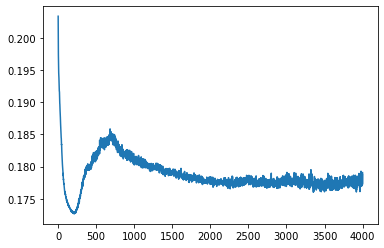

In [16]:
g_curve = [i.cpu() for i in G_loss]
plt.plot(g_curve)

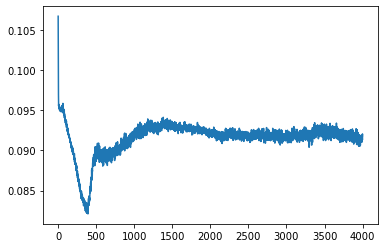

In [17]:
d_curve = [i.cpu() for i in D_loss]
plt.plot(d_curve)

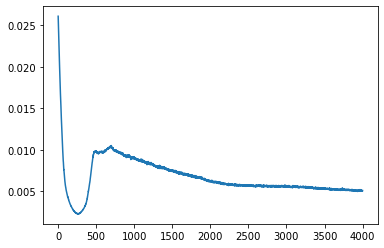

In [18]:
s_curve = [i.cpu() for i in S_loss]
plt.plot(s_curve)

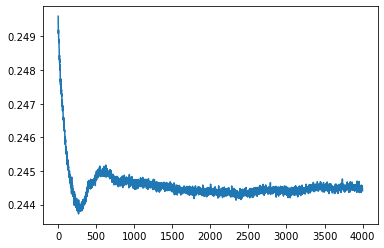

In [19]:
c_curve = [i.cpu() for i in C_loss]
plt.plot(c_curve)

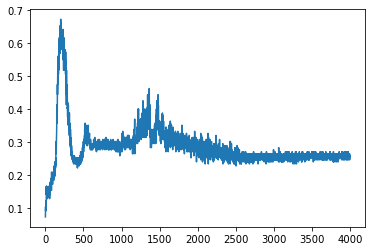

In [20]:
a_curve = [i for i in accs]
plt.plot(a_curve)

In [21]:
output = generated_img.cpu().detach()
# output = torch.reshape(output, (output.size(1), output.size(0)))

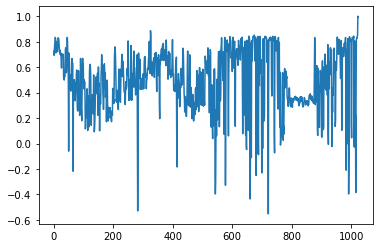

In [22]:
plt.plot(output.numpy()[1])

In [23]:
def transpose_list(my_list):
    transposed_list = list(zip(*my_list))
    for i in range(len(transposed_list)):
        transposed_list[i] = list(transposed_list[i])
    return transposed_list

In [24]:
transposed_list = transpose_list(series)

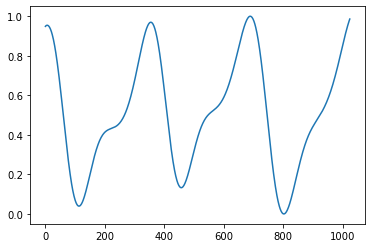

In [25]:
plt.plot(series[0])

In [26]:
auth = []
for step,(img,label) in enumerate(dataloader):
        img =img.to(device) #把数据放到设备上
        label = label.to(device)
        size = img.shape[0] #img的第一位是size,获取批次的大小
        random_seed = torch.randn(size,100,device=device)
        
        #在生成器上去计算生成器的损失，优化目标是判别器上的参数
        generated_img = gen(random_seed,label) #得到生成的图片
        generated_img = torch.reshape(generated_img, (generated_img.size(0), generated_img.size(2)))
        class_output = cls(torch.reshape(generated_img, (generated_img.size(0), 1, generated_img.size(1))))
        auth.append(class_output)

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 23.69 GiB total capacity; 3.96 GiB already allocated; 14.81 MiB free; 3.97 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
auth

In [ ]:
path = 'seed{}'.format(seed) + 'G{}'.format(generator_rate) + 'D{}'.format(discriminator_rate)
isExists=os.path.exists(path)
if not isExists:
    os.mkdir(path)
path = path + '/S{}'.format(continue_loss_weight) + 'C{}'.format(class_loss_weight)
os.mkdir(path)
torch.save(gen, path + '/generator.pt')

In [ ]:
torch.save(dis, path + "/discriminator.pt")

In [ ]:
code = []
for _, (_, _) in enumerate(dataloader):
    random_seed = torch.randn(size,100,device=device)
    code.append(random_seed.cpu().numpy())

In [ ]:
np.array(code)

In [ ]:
np.save(path + '/code.npy', code)

In [ ]:
torch.save(accs, path + '/accs.pt')